# Example of reading and plotting an HDF5 file

## HDF5 structure:

In [3]:
!h5ls -rv /home/radar/groundhog/data/6-Apr-2023-UAF-Test/2023-04-06T13-12-33.h5

Opened "/home/radar/groundhog/data/6-Apr-2023-UAF-Test/2023-04-06T13-12-33.h5" with sec2 driver.
/                        Group
    Location:  1:96
    Links:     1
/raw                     Group
    Attribute: fs scalar
        Type:      native double
    Attribute: pre_trig scalar
        Type:      native long
    Attribute: prf scalar
        Type:      native long
    Attribute: spt scalar
        Type:      native long
    Attribute: stack scalar
        Type:      native long
    Attribute: trig scalar
        Type:      native long
    Location:  1:800
    Links:     1
/raw/rx                  Dataset {512/512, 174/174}
    Location:  1:1832
    Links:     1
    Storage:   712704 logical bytes, 712704 allocated bytes, 100.00% utilization
    Type:      native long
/raw/time                Dataset {174/174}
    Location:  1:715136
    Links:     1
    Storage:   1392 logical bytes, 2784 allocated bytes, 50.00% utilization
    Type:      variable-length null-terminated UTF-8 str

## Open with Python, make some plots, print some stuff

In [27]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

### Read in file

In [53]:
# Read in file
fd = h5py.File("/home/radar/groundhog/data/6-Apr-2023-UAF-Test/2023-04-06T13-12-33.h5")

rx = fd["raw"]["rx"][:]
time = fd["raw"]["time"][:]

attrs = {}
for k in fd["raw"].attrs.keys():
    attrs[k] = fd["raw"].attrs[k]

fd.close()

### Print first and last time

In [10]:
print(time[0].decode())
print(time[-1].decode())

2023-04-06T13:12:33
2023-04-06T13:15:28


### Plot single trace

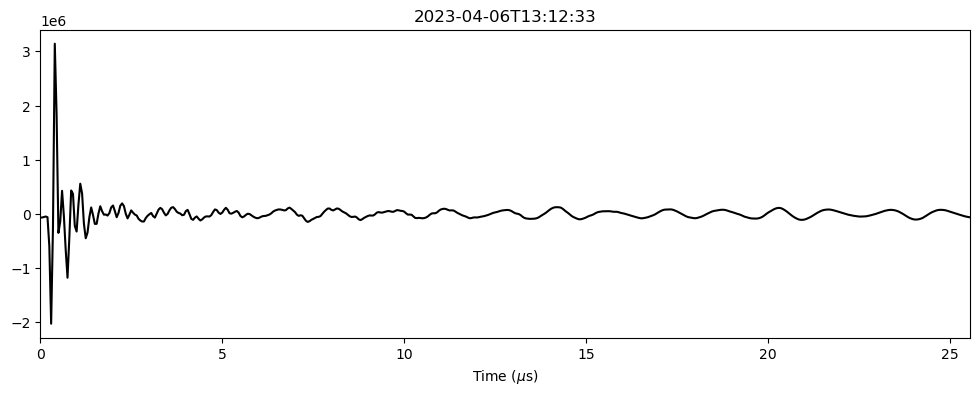

In [33]:
t = np.arange(rx.shape[0])/attrs["fs"]

trace_index = 0
plt.figure(figsize=(12,4))
plt.plot(1e6*t, rx[:,trace_index], 'k-')
plt.title(time[trace_index].decode())
plt.xlim(0, 1e6*t[-1])
plt.xlabel("Time ($\mu$s)")

plt.show()

### Plot a raw (unprocessed radargram) with a red-blue colormap

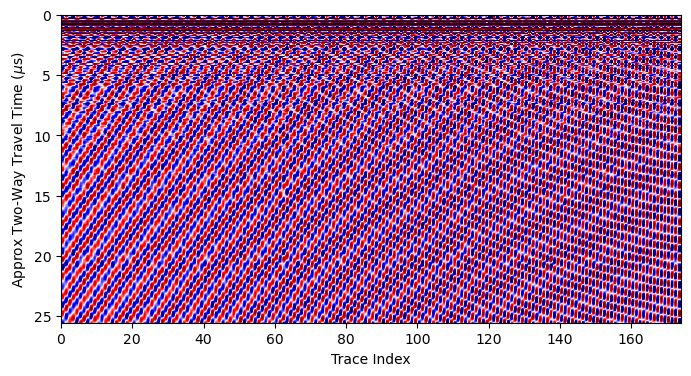

In [34]:
t = np.arange(rx.shape[0])/attrs["fs"]

plt.figure(figsize=(8, 4))
plt.imshow(
    rx,
    aspect="auto",
    cmap="seismic",
    vmin=-np.std(rx) * 0.5,
    vmax=np.std(rx) * 0.5,
    extent=[0, rx.shape[1], 1e6*t[-1], 0],
)
plt.xlabel("Trace Index")
plt.ylabel("Approx Two-Way Travel Time ($\mu$s)")

plt.show()

### Bandpass filter and then plot a radargram, also red-blue

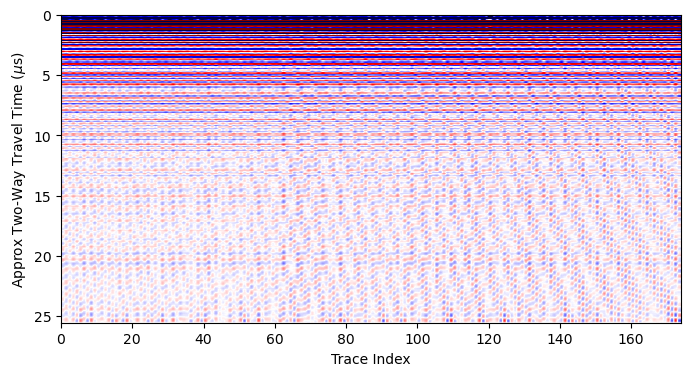

In [45]:
# Bandpass filter
flo = 1e6
fhi = 8e6
sos = sig.butter(8, [flo, fhi], btype="band", output="sos", fs=attrs["fs"])
rxfilt = sig.sosfiltfilt(sos, rx, axis=0)

# Plot 
t = np.arange(rxfilt.shape[0])/attrs["fs"]

plt.figure(figsize=(8, 4))
plt.imshow(
    rxfilt,
    aspect="auto",
    cmap="seismic",
    vmin=-np.std(rxfilt) * 0.5,
    vmax=np.std(rxfilt) * 0.5,
    extent=[0, rx.shape[1], 1e6*t[-1], 0],
)
plt.xlabel("Trace Index")
plt.ylabel("Approx Two-Way Travel Time ($\mu$s)")

plt.show()

### Make an average power-spectrum-ish thing from all of the traces in a file and plot it

Text(0.5, 0, 'Frequency (MHz)')

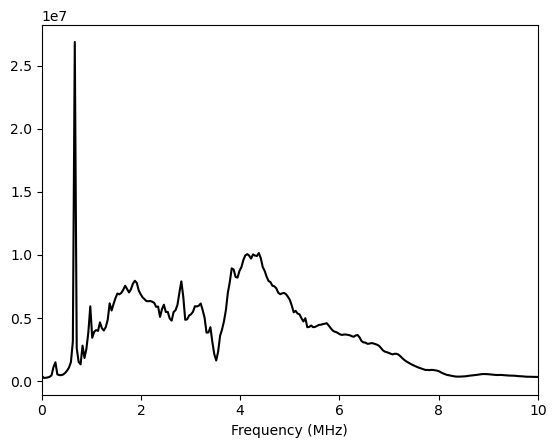

In [42]:
ps = np.zeros(rx.shape[0]//2 + 1)

for i in range(rx.shape[1]):
    ps += np.abs(np.fft.rfft(rx[:,i]))
    
ps /= rx.shape[1]

freq = np.fft.rfftfreq(rx.shape[0], d=1.0/attrs["fs"])

plt.plot(freq/1e6, ps, 'k-')
plt.xlim(0, 10)
plt.xlabel("Frequency (MHz)")

### Now the same thing but excluding the airwave

Text(0.5, 0, 'Frequency (MHz)')

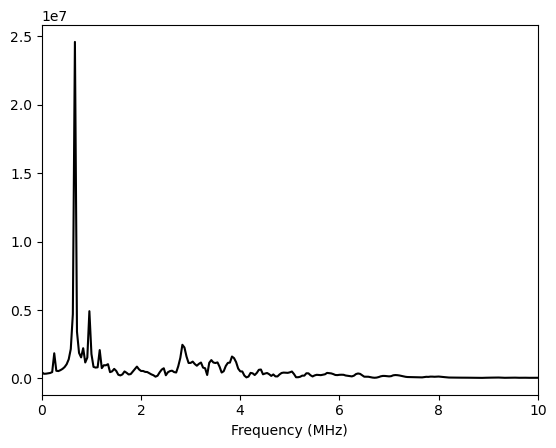

In [43]:
ncut = 32 # Number of samples to cut from the beginning of each trace

ps = np.zeros((rx.shape[0]-ncut)//2 + 1)

for i in range(rx.shape[1]):
    ps += np.abs(np.fft.rfft(rx[ncut:,i]))
    
ps /= rx.shape[1]

freq = np.fft.rfftfreq(rx.shape[0]-ncut, d=1.0/attrs["fs"])

plt.plot(freq/1e6, ps, 'k-')
plt.xlim(0, 10)
plt.xlabel("Frequency (MHz)")

I'd guess the big spike is an AM radio station

### Filter, subtract mean trace, take the envelope and plot

Text(0, 0.5, 'Approx Two-Way Travel Time ($\\mu$s)')

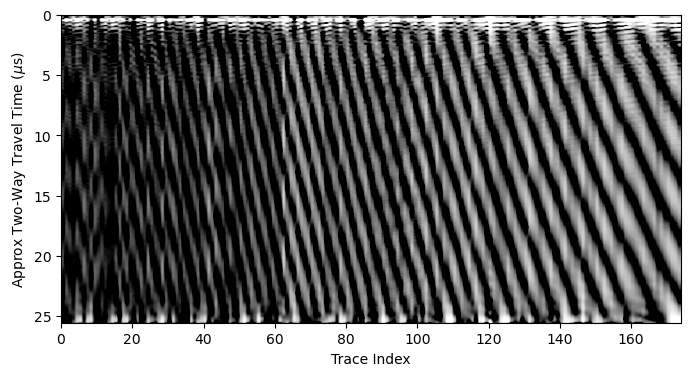

In [54]:
# Bandpass filter
flo = 1e6
fhi = 8e6
sos = sig.butter(8, [flo, fhi], btype="band", output="sos", fs=attrs["fs"])
rxfilt = sig.sosfiltfilt(sos, rx, axis=0)

# Remove mean trace
mt = np.mean(rxfilt, axis=1)
rxfilt = rxfilt - mt[:, np.newaxis]

# Take envelope
rxfilt = sig.hilbert(rxfilt, axis=0)
rxfilt = np.abs(rxfilt)

# Plot 
t = np.arange(rxfilt.shape[0])/attrs["fs"]

# Envelope image
plt.figure(figsize=(8, 4))
img = np.log10(np.abs(rxfilt))
plt.imshow(
    img,
    aspect="auto",
    cmap="Greys_r",
    vmin=np.percentile(img, 30),
    vmax=np.percentile(img, 99),
    extent=[0, rx.shape[1], 1e6*t[-1], 0],
)
plt.xlabel("Trace Index")
plt.ylabel("Approx Two-Way Travel Time ($\mu$s)")